In [1]:
import os
from sys import stdout
import scipy.io


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
from math import sqrt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model

import warnings
warnings.filterwarnings('ignore')

In [2]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
    mse = []
    component = np.arange(1, n_comp)
    for i in component:
        pls = PLSRegression(n_components=i)
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
        mse.append(mean_squared_error(y, y_cv))
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
        plt.show()
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
    
    return
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
"""   
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Brix')
        plt.ylabel('Measured $^{\circ}$Brix')
        plt.show()
    return
""" 

"   \n    # Fit a line to the CV vs response\n    z = np.polyfit(y, y_c, 1)\n    with plt.style.context(('ggplot')):\n        fig, ax = plt.subplots(figsize=(9, 5))\n        ax.scatter(y_c, y, c='red', edgecolors='k')\n        #Plot the best fit line\n        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)\n        #Plot the ideal 1:1 line\n        ax.plot(y, y, color='green', linewidth=1)\n        plt.title('$R^{2}$ (CV): '+str(score_cv))\n        plt.xlabel('Predicted $^{\\circ}$Brix')\n        plt.ylabel('Measured $^{\\circ}$Brix')\n        plt.show()\n    return\n"

In [3]:
def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
    Xc = X[:,sorted_ind]
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [8]:
x_df = pd.read_csv('avg_intensities.csv', sep = ',')
values = x_df.values
#wl=x_df.columns.values
#print(wl.shape)

#print(values)
#print(type(values))
print(values.shape)
print(values[1].shape)
print(len(values))
#x_df

(34, 3648)
(3648,)
34


[[216.33]
 [216.37]
 [216.41]
 ...
 [340.32]
 [340.34]
 [340.37]]


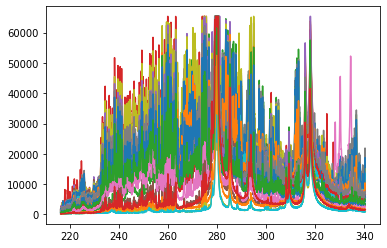

In [9]:
#This is just for visualizing the various plots of the samples

mat = scipy.io.loadmat("./data/H01.mat")
wl= mat["wl"]
print(wl)

for i in range(len(values)):
    plt.plot(wl, values[i])
    #plt.show() #comment this one to have unique plot instead of multiple ones
#range(len(dfs))
#"""



In [10]:
df_y = pd.read_csv('concentration.csv', sep = ',')
print(type(df_y))
concentration=df_y.values
print(concentration.shape)
#print(concentration)
df_y

<class 'pandas.core.frame.DataFrame'>
(34, 12)


,Sample,CaO,CaF2,MgO,Al2O3,SiO2,FeO,MnO,Cr2O3,P2O5,V2O5,TiO2
0,H01,37.8,0.18,25.00,9.61,13.20,18.30,1.99,0.20,0.23,0.18,1.03
1,H02,44.5,0.22,18.00,5.04,14.20,18.90,2.10,0.28,0.26,0.06,1.07
2,H03,38.5,0.22,21.10,6.14,10.60,20.20,5.82,0.61,0.40,0.14,0.86
3,H04,38.4,0.04,15.50,4.07,12.80,26.70,3.35,0.52,0.31,0.08,1.07
4,H05,43.2,0.18,17.10,4.14,14.80,21.70,1.72,0.20,0.29,0.18,1.07
5,H06,45.3,0.23,15.90,4.34,16.50,18.90,1.29,0.10,0.30,0.11,1.10
6,H07,46.1,0.25,14.30,4.12,16.20,19.00,1.21,0.09,0.27,0.06,1.08
7,H08,45.1,0.19,13.00,4.05,16.10,21.00,1.26,0.10,0.28,0.06,1.09
8,H09,32.8,0.01,10.60,7.30,14.30,33.20,2.75,0.42,0.32,0.09,1.12
9,H10,42.4,0.24,19.30,6.50,14.70,17.40,2.72,0.31,0.28,0.09,1.06


In [11]:
y = concentration[:,5] # 4 is aluminium, 5 is silicon
print(y)
print(y.shape)

[13.2 14.2 10.6 12.8 14.8 16.5 16.2 16.1 14.3 14.7 14.0 12.8 33.3 35.3
 35.3 29.0 34.3 34.5 32.5 30.9 27.8 25.3 24.3 21.5 5.85 25.4 28.0 13.9
 11.6 11.8 28.5 5.99 27.5 7.54]
(34,)


In [12]:
y_df= pd.DataFrame(y)
#df_y_si

In [13]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(27, 3648) (27, 1)
(7, 3648) (7, 1)


### Wavelength exploration

For Silicon (Si) the peaks are at 251.59, 288.12, 390.60 (last one not useful in this setting)

In [28]:
print(wl.T)
print(wl.shape)
print(len(wl))
print(wl[25]-wl[0])

[[216.33 216.37 216.41 ... 340.32 340.34 340.37]]
(3648, 1)
3648
[0.97]


In [15]:
target = [251.59, 288.12, 390.60]
target

[251.59, 288.12, 390.6]

In [33]:
a = []
b = []
for t in target:
    for i in range(len(wl)):
        if abs(wl[i][0]-t) < 0.01:
            a.append(wl[i][0])
            b.append(i)
            
print("number of selected wavelengths: ",len(a), "\n")
print(a, "\n")
print(b)

number of selected wavelengths:  2 

[251.58, 288.11] 

[934, 1971]


In [34]:
print(values.shape)
values[:, b].shape
x_selecta = pd.DataFrame(values[:, b])
x_selecta

(34, 3648)


,0,1
0,20100.0,15179.0
1,21470.0,14939.0
2,19505.0,20317.0
3,29489.0,20458.0
4,20751.0,19124.0
5,22365.0,15585.0
6,19819.0,15264.0
7,18807.0,13065.0
8,31245.0,24055.0
9,19991.0,16320.0


In [35]:
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

#print(X_test)

(27, 2) (27, 1)
(7, 2) (7, 1)


In [19]:
n_components= 20

# PCA

X_std = StandardScaler().fit_transform(x_selecta.values)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

principalComponents = pca.fit_transform(X_std)
print(principalComponents.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
#print(pca.singular_values_)

(34, 20)
[78.42 98.37 99.26 99.63 99.79 99.87 99.91 99.94 99.96 99.97 99.98 99.98
 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98]


In [20]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(principalComponents, y_df)
# Calibration
y_c = regr.predict(principalComponents)
# Cross-validation
y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_df, y_c)
score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_df, y_c)
mse_cv = mean_squared_error(y_df, y_cv)

print(score_c, score_cv)
print(mse_c, mse_cv)

0.8982171205829079 -0.5562524595245792
8.679408641339508 132.70749582503208


In [21]:
n_components=20

x = X_train.values
x_t = X_test.values
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
X_std_test = StandardScaler().fit_transform(x_t)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

x_pc = pca.fit_transform(X_std)
x_test1 = pca.transform(X_std_test)
print(x_pc.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

(27, 57)
(57,)
27
(27, 20)
[80.29 98.18 99.18 99.61 99.78 99.89 99.93 99.95 99.97 99.98 99.99 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99]


In [22]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(x_pc, y_train)
# Calibration
y_c = regr.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_c)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_c)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2_pred: ", score_c)
print("MSE: ", mse_c)

R2_pred:  0.8928950088699178
MSE:  11.967274762050579


In [23]:
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_selecta.values, y_df, 20)

100% completed
Optimised number of PLS components:  19
Wavelengths to be discarded  31
Optimised MSEP  28.118993002551612



sorted wavelengths:  [[218.23 217.07 216.87 216.56 217.73 217.3  216.6  216.95 216.41 217.53]]


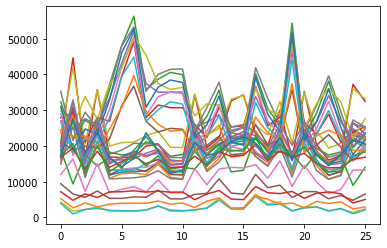

In [27]:
#print("sorted indexes: ", sorted_ind)
print("sorted wavelengths: ", wl[sorted_ind[:10]].T)

plt.plot(opt_Xc.T)
plt.show()

(27, 26) (27, 1)
(7, 26) (7, 1)
42% completed
Suggested number of components:  3



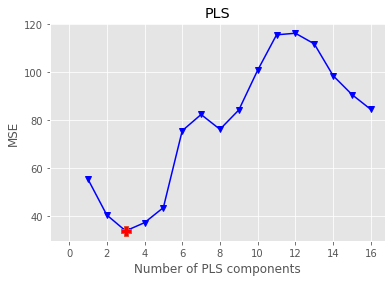

R2 calib: 0.757
R2 CV: 0.618
MSE calib: 21.364
MSE CV: 33.668


In [24]:
X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

optimise_pls_cv(X_train,y_train, 17, plot_components=True)

R2_pred: 0.46834014627124765
R2_cv: 0.5071535323831977 

[real, predictions]
[[11.6 14.09812652570156]
 [13.9 17.934131780163046]
 [35.3 27.36528515075697]
 [12.8 19.276891752627133]
 [16.2 11.154410136141367]
 [14.8 13.580131231978877]
 [28.5 17.926761409080957]]


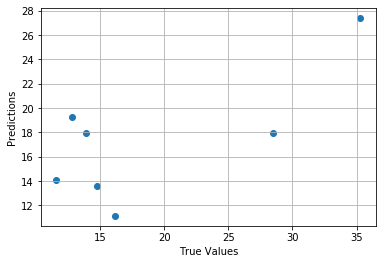

In [25]:
# Define PLS object
pls = PLSRegression(n_components=5)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_pred = pls.predict(X_test)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred:", score_pred)
print("R2_cv:",score_cv, "\n")

b=np.append(y_test, y_pred, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Principal Components Analysis

In [26]:
n_components=20

x_df = pd.read_csv('avg_intesities.csv', sep = ',')
x = x_df.values
print(x.shape)
print(x[1].shape)
print(len(x))

# PCA

X_std = StandardScaler().fit_transform(x)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

principalComponents = pca.fit_transform(X_std)
print(principalComponents.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
#print(pca.singular_values_)

FileNotFoundError: [Errno 2] File b'avg_intesities.csv' does not exist: b'avg_intesities.csv'

In [ ]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(principalComponents, y_df)
# Calibration
y_c = regr.predict(principalComponents)
# Cross-validation
y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_df, y_c)
score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_df, y_c)
mse_cv = mean_squared_error(y_df, y_cv)

print(score_c, score_cv)
print(mse_c, mse_cv)

In [ ]:
n_components=20

x = X_train.values
x_t = X_test.values
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
X_std_test = StandardScaler().fit_transform(x_t)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

x_pc = pca.fit_transform(X_std)
x_test1 = pca.transform(X_std_test)
print(x_pc.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

#### Linear regression w/ PCA

In [ ]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(x_pc, y_train)
# Calibration
y_c = regr.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_c)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_c)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2_pred: ", score_c)
print("MSE: ", mse_c)

In [ ]:
b=np.append(y_test, y_c, axis=1)

print("[real, predictions]")
print(b, "\n")

plt.scatter(y_test, y_c)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

#### PLS regression w/ PCA

In [ ]:
optimise_pls_cv(x_pc, y_train, 20, plot_components=True) 

In [ ]:
pls = PLSRegression(n_components=10)
# Fit
pls.fit(x_pc, y_train)
# Calibration
y_c = pls.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_c)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_c)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2_pred: ", score_c)
print("MSE: ", mse_c, "\n")

b=np.append(y_test, y_c, axis=1)

print("[real, predictions]")
print(b, "\n")

plt.scatter(y_test, y_c)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Linear Regression
this is ordinary least square regression on the whole spectra

In [36]:
from sklearn import linear_model

# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

R2_pred:  -2.731536538372315
R2_cv:  0.5589570731490126

TEST
 [real, predictions]
[[35.3 25.773604240107282]
 [25.3 24.772344382260858]
 [25.4 13.84871367732664]
 [35.3 30.06232083097754]
 [29.0 22.70768748119448]
 [34.3 30.038474290188063]
 [28.5 16.77918594365965]]



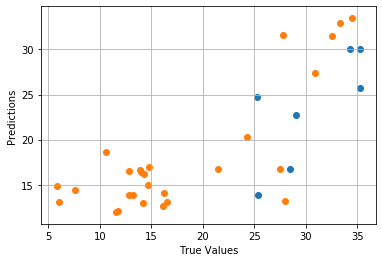

In [39]:
y_pred = lm.predict(X_test)
y_pred1 = lm.predict(X_train)

# Cross-validation
y_cv = cross_val_predict(lm, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Partial Least Square Regression

In [40]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(27, 2) (27, 1)
(7, 2) (7, 1)


#### First search for optimal number of components on the whole dataset

In [41]:
optimise_pls_cv(x_df,y_df, 40, plot_components=True)

65% completed

KeyboardInterrupt: 

5% completed
Suggested number of components:  1



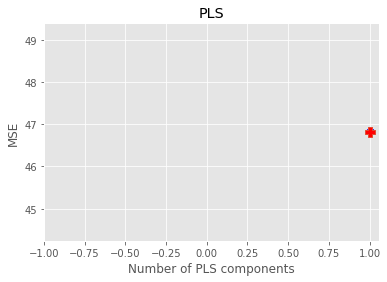

R2 calib: 0.493
R2 CV: 0.425
MSE calib: 41.313
MSE CV: 46.814


In [43]:
optimise_pls_cv(X_train,y_train, 2, plot_components=True)

R2_pred: 0.4440259018999466
R2_cv: 0.6138438446723351 

[real, predictions]
[[5.85 16.441628214638214]
 [25.4 13.822449267877616]
 [30.9 29.036061229927665]
 [28.5 18.17175451058636]
 [34.5 35.87458984335929]
 [14.8 18.40155651428159]
 [12.8 16.019087871342652]]


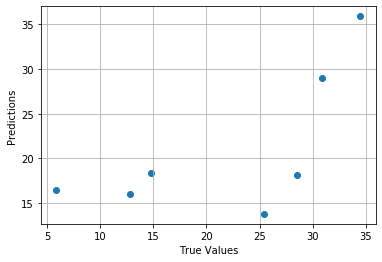

In [44]:
# Define PLS object
pls = PLSRegression(n_components=2)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_pred = pls.predict(X_test)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred:", score_pred)
print("R2_cv:",score_cv, "\n")

b=np.append(y_test, y_pred, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

In [ ]:
def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
    Xc = X[:,sorted_ind]
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [ ]:
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_df.values, y_df, 20)

In [ ]:
print("sorted indexes: ", sorted_ind.shape)
print("wav: ", wav)
print(ncomp)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

In [ ]:
optimise_pls_cv(X_train,y_train, 25, plot_components=True)

In [ ]:
# Define PLS object
pls = PLSRegression(n_components=8)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Savgol filter

In [212]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=4)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(27, 3648) (27, 1)
(7, 3648) (7, 1)


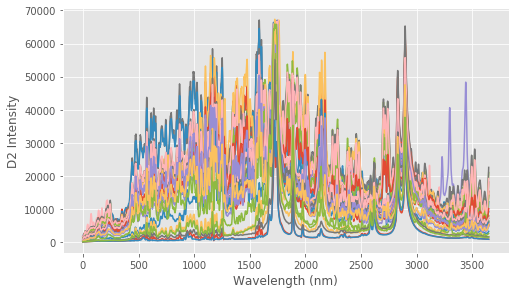

100% completed
Suggested number of components:  4



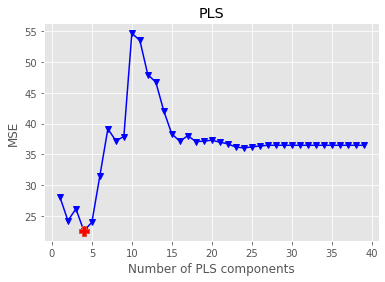

R2 calib: 0.678
R2 CV: 0.182
MSE calib: 8.880
MSE CV: 22.547


In [113]:
# Calculate second derivative
X2 = savgol_filter(x_df, 23, polyorder = 2,deriv=0) # Is this useful with LIBS spectra???
# Plot second derivative
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(range(len(X2.T)), X2.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Intensity')
    plt.show()
    
    
#X2_1 = msc(X2)[0]
    
optimise_pls_cv(X2, y_df, 40, plot_components=True)

100% completed
Suggested number of components:  1



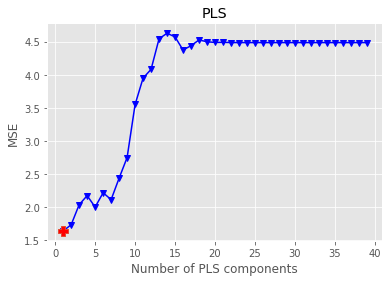

R2 calib: 0.448
R2 CV: 0.169
MSE calib: 1.092
MSE CV: 1.644


In [401]:
X2_train = savgol_filter(X_train, 17, polyorder = 4,deriv=0) 
X2_test = savgol_filter(X_test, 17, polyorder = 4,deriv=0) 

X2_train = savgol_filter(X_train, 17, polyorder = 4,deriv=1) 
X2_test = savgol_filter(X_test, 17, polyorder = 4,deriv=1) 

X2_train = savgol_filter(X_train, 17, polyorder = 8,deriv=2) 
X2_test = savgol_filter(X_test, 17, polyorder = 8,deriv=2) 


optimise_pls_cv(X2_train, y_train, 40, plot_components=True)

R2_pred:  0.5762863814088144
R2_cv:  -0.23286987488763145

[real, predictions]
[[1.6 2.5763578464001204]
 [0.0 0.12414627501779818]
 [5.82 3.2162343868766703]
 [2.0 1.611788777090525]
 [1.99 1.9860380297744138]
 [1.21 1.9013823977303057]
 [2.86 2.9779248463704744]]


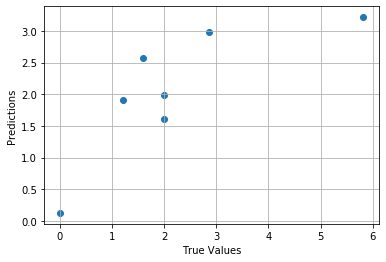

In [412]:
# Define PLS object
pls = PLSRegression(n_components=8)
# Fit
pls.fit(X2_train, y_train)
# Cross-validation
y_pred = pls.predict(X2_test)

# Cross-validation
y_cv = cross_val_predict(pls, X2_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Normalization

In [413]:
#use this if you want to try normalization on the optimized dataset (opt_Xc)
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2) 


Xn_train = normalize(X_train, axis=1)
Xn_test = normalize(X_test, axis=1)

print(Xn_test.shape)
#plt.plot(wl, X_test.T)

(7, 261)


100% completed
Suggested number of components:  6



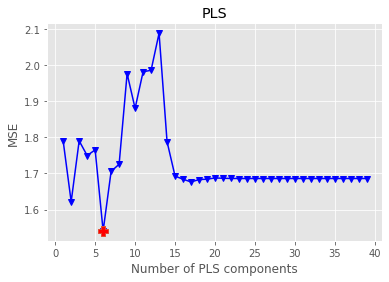

R2 calib: 0.837
R2 CV: 0.222
MSE calib: 0.323
MSE CV: 1.541


In [414]:
optimise_pls_cv(Xn_train, y_train, 40, plot_components=True)

R2_pred:  0.746303123754157
R2_cv:  0.12812487797271732

[real, predictions]
[[1.6 1.337319572982875]
 [0.0 -1.0572710481473233]
 [5.82 4.042511781674474]
 [2.0 2.031979636374199]
 [1.99 2.172305786212815]
 [1.21 1.9902214107373024]
 [2.86 2.67361133016861]]


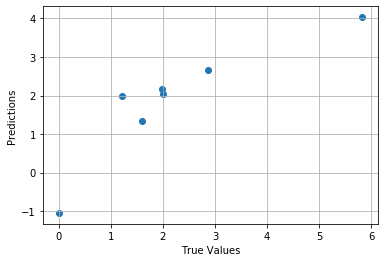

In [423]:
# Define PLS object
pls = PLSRegression(n_components=8)
# Fit
pls.fit(Xn_train, y_train)
# Cross-validation
y_pred = pls.predict(Xn_test)

# Cross-validation
y_cv = cross_val_predict(pls, Xn_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Elastic Net

In [221]:
from sklearn.linear_model import ElasticNet,ElasticNetCV

In [222]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

In [424]:
for a in alphas:
    model = ElasticNet(alpha=a).fit(X_train,y_train)   
    score = model.score(X_train, y_train)
    pred_y = model.predict(X_test)
    mse = mean_squared_error(y_test, pred_y)   
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))

Alpha:0.0001, R2:1.00, MSE:7.55, RMSE:2.75
Alpha:0.0010, R2:1.00, MSE:7.55, RMSE:2.75
Alpha:0.0100, R2:1.00, MSE:7.55, RMSE:2.75
Alpha:0.1000, R2:1.00, MSE:7.73, RMSE:2.78
Alpha:0.3000, R2:1.00, MSE:7.89, RMSE:2.81
Alpha:0.5000, R2:1.00, MSE:7.98, RMSE:2.82
Alpha:0.7000, R2:1.00, MSE:8.09, RMSE:2.84
Alpha:1.0000, R2:1.00, MSE:7.72, RMSE:2.78


In [429]:
model = ElasticNet(alpha=0.001).fit(X_train,y_train)   
score = model.score(X_train, y_train)
print("Train score: ", score)
pred_y = model.predict(X_test)


rmse = sqrt(mean_squared_error(y_test, pred_y))
r2 = r2_score(y_test, pred_y)
print("RMSE: ", rmse)
print("R^2: ", r2)

Train score:  0.9999952526075552
RMSE:  2.748305990646831
R^2:  -1.669875165687063


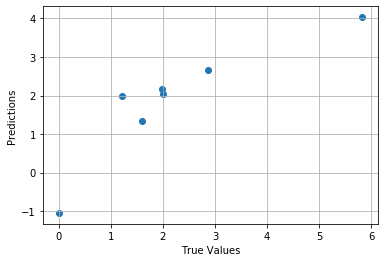

In [430]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Random Forest

In [66]:
y_test=np.ravel(y_test)
print(y_test.shape)
y_train=np.ravel(y_train)
print(y_train.shape)

(7,)
(27,)


In [67]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 150, random_state = 69)
# Train the model on training data
rf.fit(X_train, y_train);

In [68]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.71


In [69]:
rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print("R^2: ", r2)
print("RMSE: ", rmse)

R^2:  0.3877622372987447
RMSE:  0.8135686778943697


In [70]:
y_test= y_test.reshape((len(y_test), 1))
print(y_test.shape)
print(type(y_test))
predictions=predictions.reshape((len(y_test), 1))
print(predictions.shape)
print(type(y_test))
#print((y_test, predictions))

(7, 1)
<class 'numpy.ndarray'>
(7, 1)
<class 'numpy.ndarray'>


In [71]:
b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

[real, predictions]
[[0.41 1.6207333333333318]
 [1.36 1.8407333333333311]
 [2.1 1.5204000000000002]
 [3.5 2.2115333333333367]
 [3.35 3.8558666666666688]
 [2.0 2.81946666666667]
 [1.26 1.1470000000000002]]


Text(0, 0.5, 'Predictions')

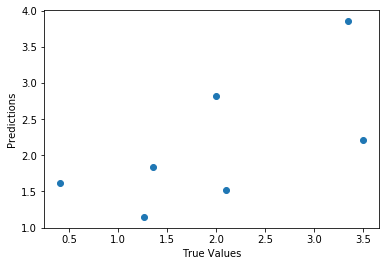

In [72]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

#### This is a trial with PC as input 

In [438]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 2000, max_depth=30, random_state = 42)
# Train the model on training data
rf.fit(x_pc, y_train)
# Calibration
y_p = rf.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_p)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_p)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2: ", score_c)
print("MSE: ", mse_c)

R2:  -0.13304307573634944
MSE:  3.2054251079142846


# MultiOutput Random Forest

In [47]:
bau = input("do you want to continue? ")

do you want to continue? 


In [48]:
multi_y = concentration[:,1:]
#print (multi_y)
print (type(multi_y))
df_y= pd.DataFrame(multi_y)
print (type(df_y))
df_y

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


,0,1,2,3,4,5,6,7,8,9,10
0,37.8,0.18,25,9.61,13.2,18.3,1.99,0.2,0.23,0.18,1.03
1,44.5,0.22,18,5.04,14.2,18.9,2.1,0.28,0.26,0.06,1.07
2,38.5,0.22,21.1,6.14,10.6,20.2,5.82,0.61,0.4,0.14,0.86
3,38.4,0.04,15.5,4.07,12.8,26.7,3.35,0.52,0.31,0.08,1.07
4,43.2,0.18,17.1,4.14,14.8,21.7,1.72,0.2,0.29,0.18,1.07
5,45.3,0.23,15.9,4.34,16.5,18.9,1.29,0.1,0.3,0.11,1.1
6,46.1,0.25,14.3,4.12,16.2,19,1.21,0.09,0.27,0.06,1.08
7,45.1,0.19,13,4.05,16.1,21,1.26,0.1,0.28,0.06,1.09
8,32.8,0.01,10.6,7.3,14.3,33.2,2.75,0.42,0.32,0.09,1.12
9,42.4,0.24,19.3,6.5,14.7,17.4,2.72,0.31,0.28,0.09,1.06


In [49]:
X_train, X_test, y_train, y_test = train_test_split(x_df, df_y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(27, 3648) (27, 11)
(7, 3648) (7, 11)


In [50]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=500,
                                                          max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=30,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=500,
                                                

In [51]:
y_multirf = regr_multirf.predict(X_test)

In [52]:
print(y_test.shape)
print(y_multirf.shape)

(7, 11)
(7, 11)


In [53]:
rmse = sqrt(mean_squared_error(y_test, y_multirf))
r2 = r2_score(y_test, y_multirf)

print("R^2: ", r2)
print("RMSE: ", rmse)

R^2:  -2.4536787314137825
RMSE:  3.2696541804501393


In [54]:
b=np.append(np.around(y_test,3), np.around(y_multirf,3), axis=1)

print("[real, predictions]")
print(b)

[real, predictions]
[[39.2 1.1 8.4 3.7 34.3 1.7 1.3 9.3 0.01 0.11 0.92 40.559 1.317 8.521
  3.939 25.406 2.591 2.717 8.112 0.018 0.166 1.102]
 [32.8 0.01 10.6 7.3 14.3 33.2 2.75 0.42 0.32 0.09 1.12 38.187 1.239
  13.097 5.132 26.534 25.305 3.942 4.92 0.152 0.282 0.668]
 [40.3 1.2 7.7 4.8 30.9 1.7 3.3 7.6 0.01 0.18 1.45 41.214 1.23 9.129
  3.973 26.153 2.065 2.296 6.938 0.011 0.148 0.998]
 [45.3 0.23 15.9 4.34 16.5 18.9 1.29 0.1 0.3 0.11 1.1 42.105 0.396 16.975
  5.725 13.12 19.43 2.209 0.576 0.202 0.132 0.822]
 [38.4 0.04 15.5 4.07 12.8 26.7 3.35 0.52 0.31 0.08 1.07 36.973 1.289
  14.138 5.601 22.114 25.602 3.606 4.386 0.155 0.77 0.604]
 [40.1 2.43 20.0 6.79 27.5 1.37 0.41 0.89 0.0 0.22 0.24 40.308 0.849
  16.817 7.212 12.927 2.422 1.758 0.777 0.005 0.161 0.41]
 [44.2 1.1 10.5 3.2 34.5 1.0 1.1 3.2 0.01 0.08 0.98 40.015 1.324 7.935
  3.71 31.015 2.446 3.17 8.266 0.026 0.229 1.263]]


Text(0, 0.5, 'Predictions')

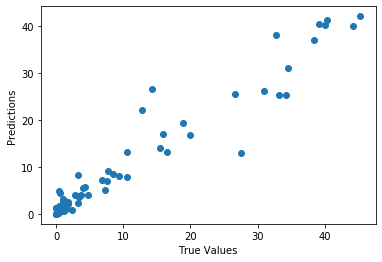

In [55]:
plt.scatter(y_test, y_multirf)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [56]:
y_pred=np.around(y_multirf,2)
y_pred[:,0]

array([40.56, 38.19, 41.21, 42.1 , 36.97, 40.31, 40.01])

In [57]:
y_test[0].values

array([39.2, 32.8, 40.3, 45.3, 38.4, 40.1, 44.2], dtype=object)

In [58]:
print("real: ", y_test[0].values)
print("pred: ", y_pred[:,0])

real:  [39.2 32.8 40.3 45.3 38.4 40.1 44.2]
pred:  [40.56 38.19 41.21 42.1  36.97 40.31 40.01]


# PLS-2

In [59]:
#optimise_pls_cv(x_df, df_y, 40, plot_components=True)

# the optimal number of components is 6 on the whole dataset

100% completed
Suggested number of components:  6



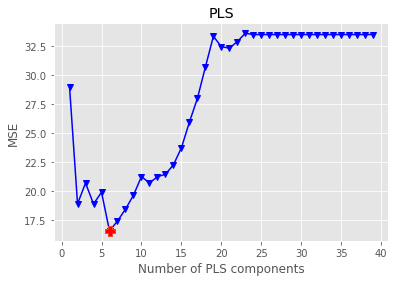

R2 calib: 0.648
R2 CV: 0.167
MSE calib: 6.691
MSE CV: 16.568


In [60]:
optimise_pls_cv(X_train, y_train, 40, plot_components=True)

In [61]:
# Define PLS object
pls = PLSRegression(n_components= 6)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)
# Calculate scores
score = r2_score(y_train, y_cv)
mse = mean_squared_error(y_train, y_cv)

print("R^2: ", score)
print("MSE: ", mse)

R^2:  0.16727823583868234
MSE:  16.56841242368313


In [62]:
y_pred = pls.predict(X_test)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print(score_pred) #not so good
print(score_cv)

-6.042330324475305
0.16727823583868234


In [63]:
# test real values
np.round(y_test, decimals=2)

,0,1,2,3,4,5,6,7,8,9,10
16,39.2,1.1,8.4,3.7,34.3,1.7,1.3,9.3,0.01,0.11,0.92
8,32.8,0.01,10.6,7.3,14.3,33.2,2.75,0.42,0.32,0.09,1.12
19,40.3,1.2,7.7,4.8,30.9,1.7,3.3,7.6,0.01,0.18,1.45
5,45.3,0.23,15.9,4.34,16.5,18.9,1.29,0.1,0.3,0.11,1.1
3,38.4,0.04,15.5,4.07,12.8,26.7,3.35,0.52,0.31,0.08,1.07
32,40.1,2.43,20,6.79,27.5,1.37,0.41,0.89,0,0.22,0.24
17,44.2,1.1,10.5,3.2,34.5,1,1.1,3.2,0.01,0.08,0.98


In [64]:
# test predicted values
pd.DataFrame(np.round(y_pred, decimals=2))

,0,1,2,3,4,5,6,7,8,9,10
0,40.91,1.26,4.25,4.96,25.90,4.22,3.20,10.79,0.01,0.60,1.23
1,44.12,-1.38,18.47,2.92,8.15,35.75,3.88,-5.73,0.47,-0.58,1.34
2,43.52,1.12,10.07,6.97,29.35,0.63,1.92,4.52,0.01,0.06,1.05
3,44.39,-0.18,18.91,7.33,13.59,22.71,2.01,-4.85,0.29,-0.37,0.98
4,42.99,-0.91,16.34,2.08,7.77,36.74,3.51,-3.79,0.44,-0.37,1.24
5,39.29,1.98,17.59,7.84,24.36,4.88,1.17,2.46,0.05,0.36,0.56
6,42.75,0.49,5.83,4.01,26.48,6.41,3.70,7.84,0.07,0.22,1.45
